### Description

#### Evaluates a number of estimators to construct the Voting Regressor meta-estimator with weights such that the mean squared error of the combined predictions of the estimators is minimized.

In [36]:
# Import Dependencies
import pandas as pd
import numpy as np
import joblib

# Plots as needed
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from sklearn.preprocessing import RobustScaler

# Data split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

# Model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import ARDRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import HuberRegressor


# Model Validation and Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import PredictionErrorDisplay
from mlxtend.evaluate import bias_variance_decomp
from scipy import stats

# MSE minimization
from sklearn.metrics import mean_squared_error
from scipy import optimize

# DB interface
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from config import db_password

ModuleNotFoundError: No module named 'config'

## Interface with Database and create DataFrames

In [6]:
# Construct db string
user = 'postgres'
host = 'housing-prices.ch2ctomvepex.us-east-1.rds.amazonaws.com'
name = 'housing-prices'

db_string = f'postgresql://{user}:{db_password}@{host}/{name}'

In [7]:
# Create Connection Engine

engine = create_engine(db_string)

In [8]:
# map to Base to extract metadata
Base = automap_base()
Base.prepare(engine, reflect=True)

In [9]:
# List of tables corresponding to cities
table_names = []
city_list = ['austin','boston','sanfran','chandler','chicago','houston','la','pittsburgh','spokane']

# Group by city population
# To generalize, pop groups can be calc. based on population of known cities in groups.
low_list = ['chandler', 'pittsburgh', 'spokane']
mid_list = ['austin', 'boston', 'sf']
high_list = ['chicago', 'la', 'houston']

for k in Base.metadata.tables.keys():
    if k in city_list:
        table_names.append(k)

print(table_names)

['austin', 'sanfran', 'la', 'boston', 'chandler', 'pittsburgh', 'houston', 'spokane', 'chicago']


In [10]:
# Create df from comb. of all city tables

def city_df(eng,city_tables,lowpop_list=[],midpop_list=[],highpop_list=[]):
    
    all_pop = pd.DataFrame()
    
    for city in city_tables:
        
        if city in lowpop_list:
            
            # Create temp city df
            city = pd.read_sql_table(city, eng)
            
            # Add class col
            city['pop_class'] = 1
            
            # add to all_pop
            all_pop = pd.concat([all_pop,city])
            
        elif city in midpop_list:
            
            # Create temp city df
            city = pd.read_sql_table(city, eng)
            
            # Add class col
            city['pop_class'] = 2
            
            # add to all_pop
            all_pop = pd.concat([all_pop,city])
            
        elif city in highpop_list:
            
            # Create temp city df
            city = pd.read_sql_table(city, eng)
            
            # Add class col
            city['pop_class'] = 3
            
            # add to all_pop
            all_pop = pd.concat([all_pop,city])
               
    return all_pop

In [11]:
all_pop = city_df(eng=engine,city_tables=table_names,lowpop_list=low_list,
                  midpop_list=mid_list,highpop_list=high_list)
all_pop.head()

,price,bedroom,sqft,bathroom,amenity_count,cityid,pop_class
0,1191,1,600.0,1.0,5,1,2
1,1425,1,526.0,1.0,5,1,2
2,1266,1,578.0,1.0,5,1,2
3,1144,1,351.0,1.0,8,1,2
4,1775,4,1236.0,2.0,8,1,2


In [12]:
# Write to csv to prevent constant db calls
# all_pop.to_csv('all_pop.csv',index=False)

In [2]:
# df from csv if needed
# all_pop = pd.read_csv('all_pop.csv')

## Examine data

In [3]:
all_pop.describe()

,price,bedroom,sqft,bathroom,amenity_count,cityid,pop_class
count,4481.000000,4481.000000,4481.000000,4481.000000,4481.000000,4481.000000,4481.000000
mean,1842.516849,1.674403,939.883731,1.462174,5.571301,5.198393,1.950904
std,935.202674,0.942777,494.403762,0.633749,1.864343,2.632753,0.867467
min,225.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,1300.000000,1.000000,680.000000,1.000000,4.000000,3.000000,1.000000
50%,1653.000000,2.000000,875.000000,1.000000,6.000000,5.000000,2.000000
75%,2201.000000,2.000000,1114.000000,2.000000,7.000000,7.000000,3.000000
max,20000.000000,8.000000,15492.000000,5.000000,11.000000,9.000000,3.000000


In [4]:
# Check dtypes
all_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4481 entries, 0 to 4480
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          4481 non-null   int64  
 1   bedroom        4481 non-null   int64  
 2   sqft           4481 non-null   float64
 3   bathroom       4481 non-null   float64
 4   amenity_count  4481 non-null   int64  
 5   cityid         4481 non-null   int64  
 6   pop_class      4481 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 245.2 KB


In [6]:
all_t = all_pop.copy()

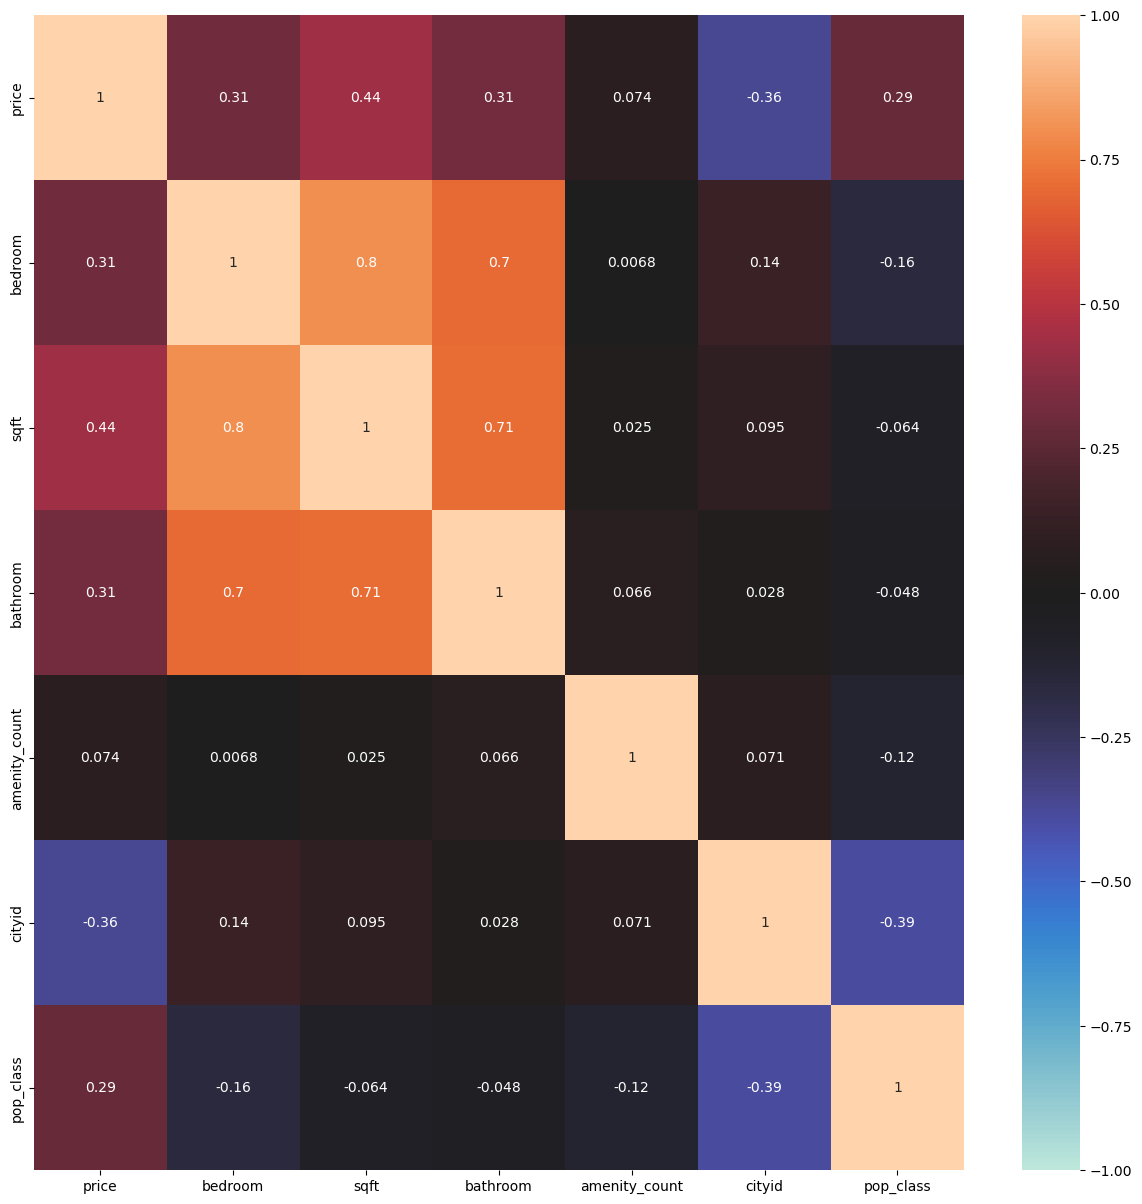

In [135]:
# Plot Corr
plt.figure(figsize=[15,15])
sns.heatmap(all_t.corr(), annot=True, vmin=-1, vmax=1, center=0)
plt.savefig('figs/corr_heatmap.png')

### Stats

In [10]:
pop_price = all_t.drop(columns=['bedroom','sqft','bathroom','amenity_count','cityid'])
pop_price.head()

,price,pop_class
0,1191,2
1,1425,2
2,1266,2
3,1144,2
4,1775,2


In [25]:
# Overall mean price
mean_price = pop_price.price.mean()
std_price = pop_price.price.std()
n_price = len(pop_price.price)

In [32]:
mean_price_1 = pop_price.groupby(['pop_class']).mean().price[1]
std_price_1 = pop_price.groupby(['pop_class']).std().price[1]
n_price_1 = pop_price.groupby(['pop_class']).count().price[1]
mean_price_2 = pop_price.groupby(['pop_class']).mean().price[2]
std_price_2 = pop_price.groupby(['pop_class']).std().price[2]
n_price_2 = pop_price.groupby(['pop_class']).count().price[2]
mean_price_3 = pop_price.groupby(['pop_class']).mean().price[3]
std_price_3 = pop_price.groupby(['pop_class']).std().price[3]
n_price_3 = pop_price.groupby(['pop_class']).count().price[3]

In [61]:
pop_t_1 = stats.ttest_ind_from_stats(mean1=mean_price,std1=std_price,nobs1=n_price,
                    mean2=mean_price_1,std2=std_price_1,nobs2=n_price_1,
                    equal_var=False)


In [52]:
pop_t_2 = stats.ttest_ind_from_stats(mean1=mean_price,std1=std_price,nobs1=n_price,
                    mean2=mean_price_2,std2=std_price_2,nobs2=n_price_2,
                    equal_var=False)

In [53]:
pop_t_3 = stats.ttest_ind_from_stats(mean1=mean_price,std1=std_price,nobs1=n_price,
                    mean2=mean_price_3,std2=std_price_3,nobs2=n_price_3,
                    equal_var=False)

In [60]:
pd.DataFrame({'Mean Price':[mean_price_1,mean_price_2,mean_price_3,mean_price],
             'Standard Deviation': [std_price_1,std_price_2,std_price_3,std_price],
             'Test Statistic': [pop_t_1[0],pop_t_2[0],pop_t_3[0],'N/A'],
             'P-Value': [pop_t_1[1],pop_t_2[1],pop_t_3[1],'N/A']},
            index=['Low Pop','Mid Pop', 'High Pop', 'All'])

,Mean Price,Standard Deviation,Test Statistic,P-Value
Low Pop,1443.863409,510.251966,21.628192,0.0
Mid Pop,2260.303003,974.229464,-12.83944,0.0
High Pop,2006.228336,1092.849251,-5.309823,0.0
All,1842.516849,935.202674,N/A,N/A


## Outlier removal

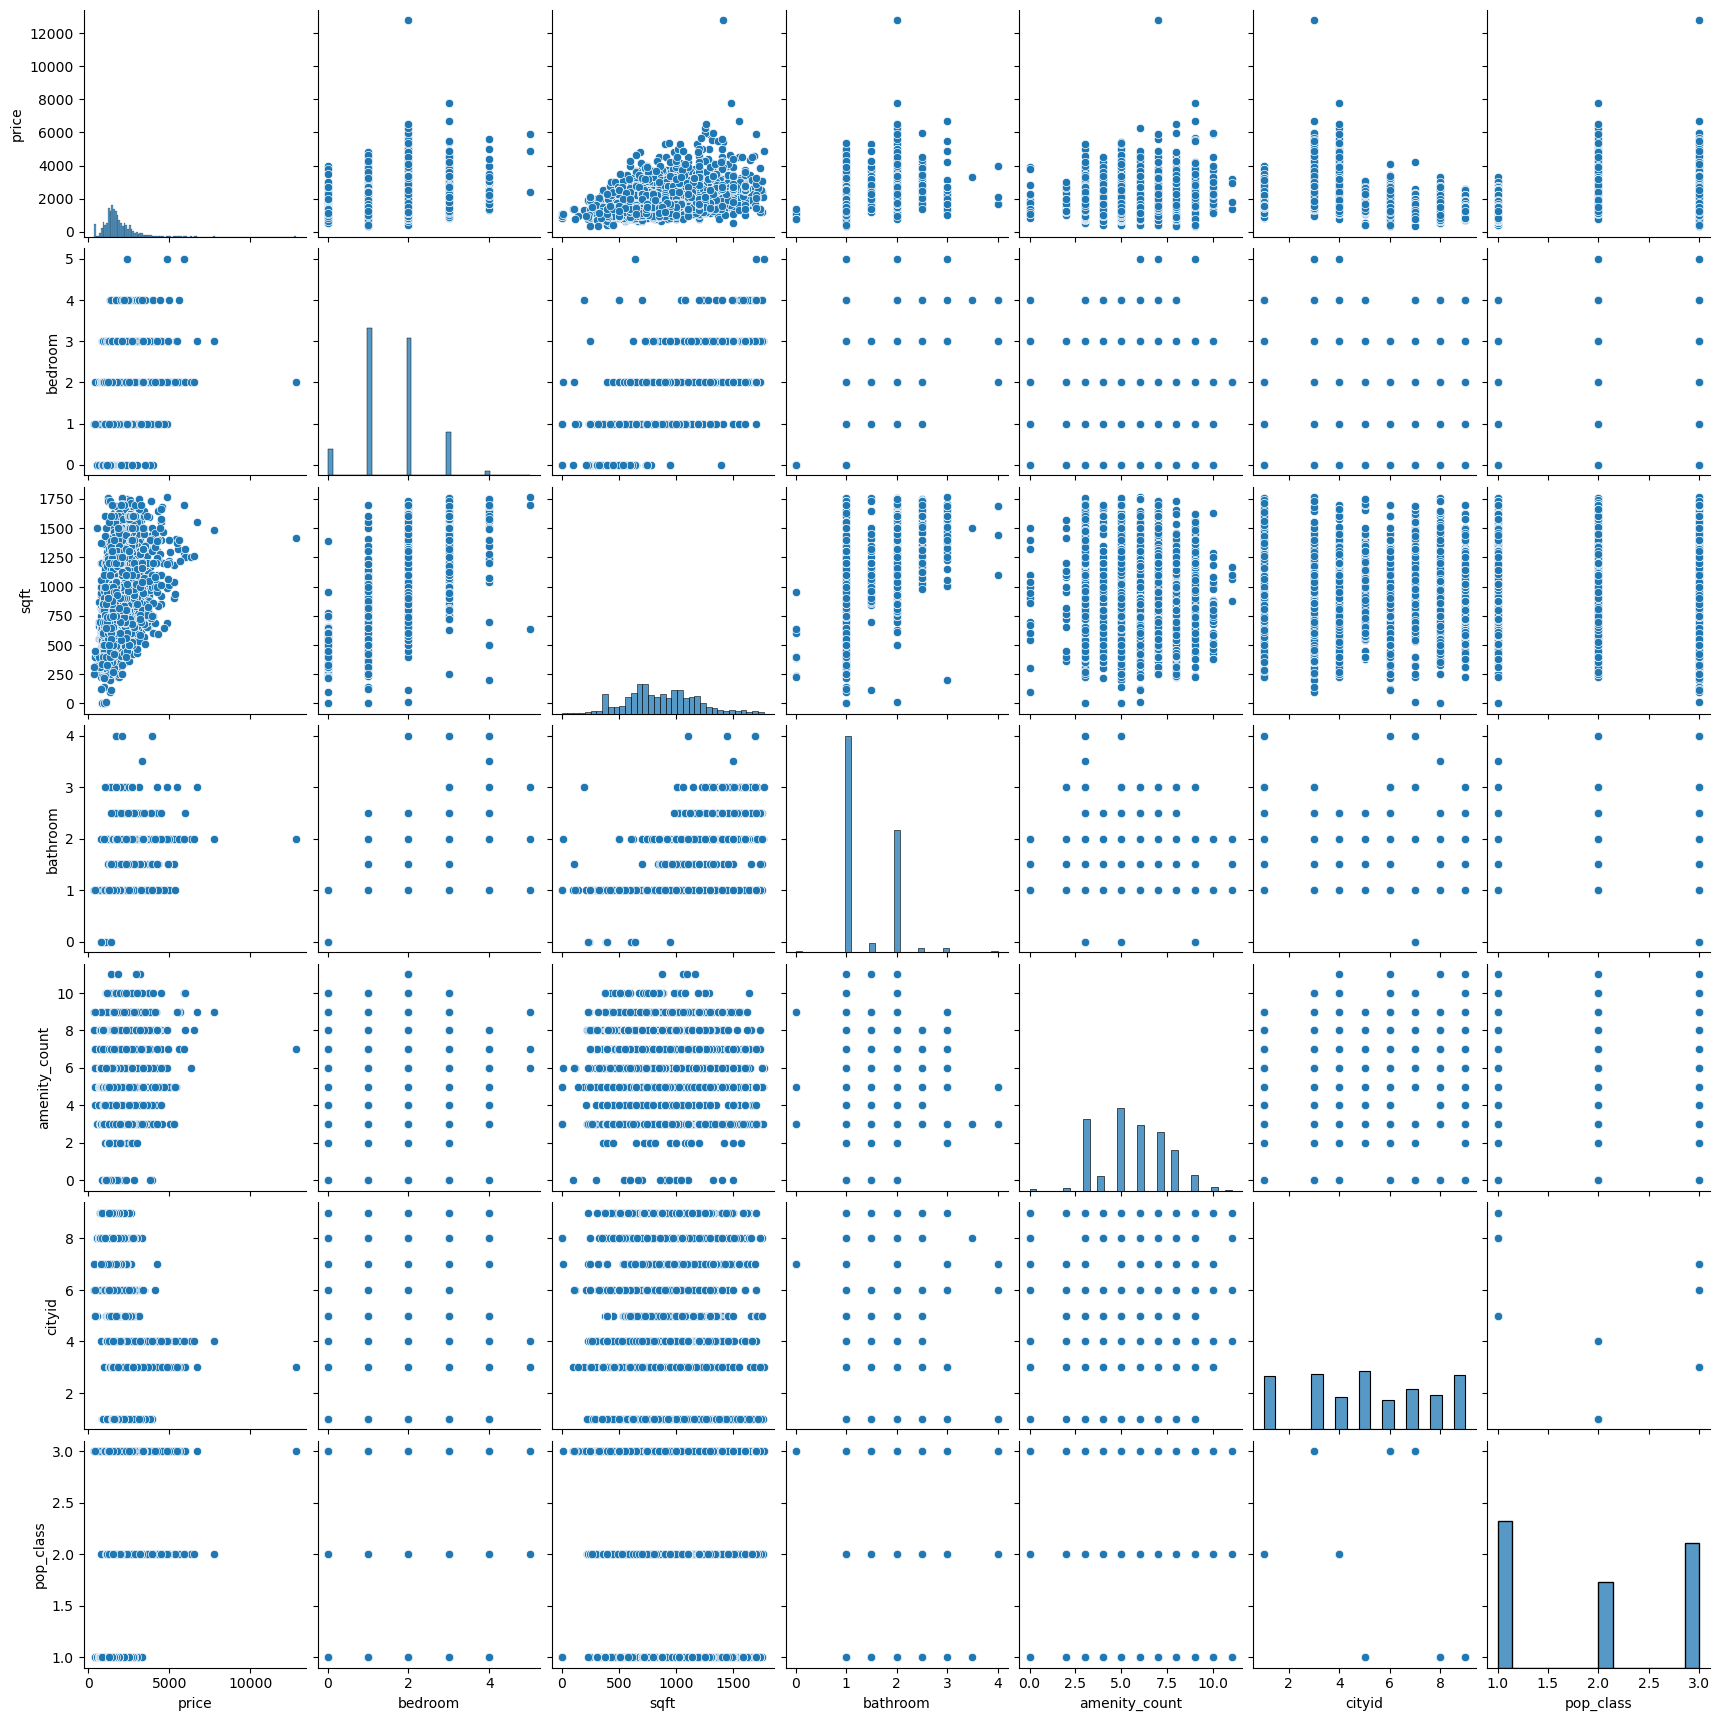

In [127]:
sns.pairplot(all_t)

### Price is significantly skewed, use log2 transform.

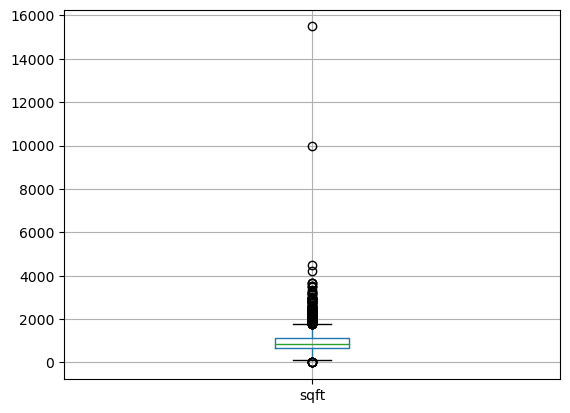

In [7]:
# Dist of num ft 'sqft' -> appears many outside 1.5*IQR
all_t.boxplot(column='sqft')
plt.savefig('figs/sqft')
plt.show()

In [8]:
# Calc iqr of sqft and upper/lower bounds
sqft_iqr = all_t.sqft.quantile(.75)-all_t.sqft.quantile(.25)
upper = 1.5*sqft_iqr + all_t.sqft.quantile(.75)
lower =  all_t.sqft.quantile(.25) - 1.5*sqft_iqr
print(lower)
print(upper)

29.0
1765.0


In [9]:
all_t.drop(all_t[all_t.sqft > upper].index, inplace=True)

## Split Train and Test Data

In [10]:
# Before examination, split so that the test set remains unobserved

# Split using SSS to incorporate data from each of the 3 groups in test and train sets.
split = StratifiedShuffleSplit(n_splits=10,test_size=0.2, random_state=42)

for train_index, test_index in split.split(all_t, all_t['cityid']):
    strat_train_set = all_t.iloc[train_index]
    strat_test_set = all_t.iloc[test_index]

In [11]:
# Create a new df that is a copy of the training set to preserve it.
all_train = strat_train_set.copy()

# Repeat for test set
all_test = strat_test_set.copy()

# Show first 5 rows of training set
all_train.head()

,price,bedroom,sqft,bathroom,amenity_count,cityid,pop_class
3735,1458,2,875.0,1.0,7,9,1
1321,1725,2,822.0,2.0,6,3,3
1141,3070,1,680.0,1.0,7,3,3
3375,1695,4,1687.0,4.0,5,7,3
3631,1145,2,928.0,1.0,6,9,1


In [9]:
# Compare Train Test Split
train_set,test_set = train_test_split(all_t, test_size=0.2, random_state=42)

In [10]:
# df for comparison of test sets
split_comp = pd.DataFrame()
split_comp['Overall'] = all_t.cityid.value_counts() / len(all_t.cityid)
split_comp['Strat_City'] = all_test.cityid.value_counts() / len(all_test.cityid)
split_comp['Random'] = test_set.cityid.value_counts() / len(test_set.cityid)
split_comp['Random %Error'] = ((split_comp.Random - split_comp.Overall) / split_comp.Overall)*100
split_comp['Strat_City %Error'] = ((split_comp.Strat_City - split_comp.Overall) / split_comp.Overall)*100
split_comp

,Overall,Strat_City,Random,Random %Error,Strat_City %Error
5,0.162541,0.162194,0.163361,0.504299,-0.213589
3,0.154601,0.155193,0.166861,7.930425,0.382843
9,0.152032,0.151692,0.140023,-7.898628,-0.223514
1,0.149229,0.149358,0.162194,8.687546,0.086373
7,0.112331,0.112019,0.086348,-23.130778,-0.277766
8,0.096450,0.096849,0.091015,-5.635120,0.413911
4,0.091079,0.091015,0.107351,17.866140,-0.070012
6,0.081738,0.081680,0.082847,1.357560,-0.070012


#### Stratified Shuffle Split demonstrates better representation of the population groupings

### Preprocess Finalized Feature Set

In [12]:
# Remove target

X_train = all_train.drop(columns='price').values
y_train = np.log(all_train.price.values)

X_test = all_test.drop(columns='price').values
y_test = np.log(all_test.price.values)

In [13]:
# Scale using RobustScaler due to spread

rs = RobustScaler()

robust = rs.fit(X_train)

X_train_scaled = robust.transform(X_train)

X_test_scaled = robust.transform(X_test)

## Estimator Construction

In [14]:
# Create fn to out scores from cross_val_score to select estimators

def score_info(scores):
    MSE = -scores
    confidence = 0.95
    con_int= stats.t.interval(
    confidence,
    len(MSE)-1,
    loc=MSE.mean(),
    scale=stats.sem(MSE))
    
    print(f'Mean: {MSE.mean()}')
    print(f'STD: {MSE.std()}')
    print(f'Conf. Interval: {con_int}')
    return [MSE.mean(), MSE.std(), con_int[0], con_int[1]]

In [13]:
# Gradient Boosting Regressor

gbr_cvs = cross_val_score(GradientBoostingRegressor(random_state=42),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

gbr_score = score_info(gbr_cvs)

Mean: 0.03938417084760333
STD: 0.006123236413511596
Conf. Interval: (0.03587421935041637, 0.04289412234479029)


In [14]:
# Random Forest Regressor

rfr_cvs = cross_val_score(RandomForestRegressor(random_state=42),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

rfr_score =score_info(rfr_cvs)

Mean: 0.03190887958473458
STD: 0.005915754232067833
Conf. Interval: (0.028517860682048, 0.03529989848742116)


In [15]:
# Lasso

lasso_cvs = cross_val_score(LassoCV(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

lasso_score=score_info(lasso_cvs)

Mean: 0.1179644639990261
STD: 0.013796802493177832
Conf. Interval: (0.11005588358549433, 0.12587304441255787)


In [16]:
# Ridge

ridge_cvs = cross_val_score(RidgeCV(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

ridge_score=score_info(ridge_cvs)

Mean: 0.11798450658092041
STD: 0.013853060586195683
Conf. Interval: (0.1100436779959182, 0.1259253351659226)


In [17]:
# Adaboost

ada_cvs = cross_val_score(AdaBoostRegressor(random_state=42),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

ada_score=score_info(ada_cvs)

Mean: 0.06872490937882217
STD: 0.009041824358985177
Conf. Interval: (0.06354196970396464, 0.0739078490536797)


In [18]:
#ARDRegression

ard_cvs = cross_val_score(ARDRegression(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

ard_score=score_info(ard_cvs)

Mean: 0.11799110975875754
STD: 0.013816831597245298
Conf. Interval: (0.11007104829516312, 0.12591117122235196)


In [19]:
# SVM with polynomial kernel

svp_cvs = cross_val_score(SVR(kernel='poly'),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

svp_score = score_info(svp_cvs)

Mean: 0.07690713711157901
STD: 0.01625048488983719
Conf. Interval: (0.06759206091376364, 0.08622221330939438)


In [20]:
svl_cvs = cross_val_score(SVR(kernel='linear'),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

svl_score = score_info(svl_cvs)

Mean: 0.12024019843685285
STD: 0.015898638822804304
Conf. Interval: (0.11112680686239065, 0.12935359001131505)


In [21]:
svr_cvs = cross_val_score(SVR(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

svr_score = score_info(svr_cvs)

Mean: 0.04298881026946955
STD: 0.005565389510852006
Conf. Interval: (0.03979862685552539, 0.046178993683413716)


In [22]:
svs_cvs = cross_val_score(SVR(kernel='sigmoid'),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

svs_score = score_info(svs_cvs)

Mean: 2180.5429425669336
STD: 412.4174824335233
Conf. Interval: (1944.1376721874637, 2416.948212946403)


In [23]:
# K nearest regression

knn_cvs = cross_val_score(KNeighborsRegressor(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

knn_score = score_info(knn_cvs)

Mean: 0.04172888488869762
STD: 0.009078558019800707
Conf. Interval: (0.036524888805256533, 0.04693288097213871)


In [24]:
bag_cvs = cross_val_score(BaggingRegressor(random_state=42),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

bag_score= score_info(bag_cvs)

Mean: 0.03330249180079607
STD: 0.005732797875712841
Conf. Interval: (0.030016346839525677, 0.036588636762066466)


In [25]:
hbr_cvs = cross_val_score(HuberRegressor(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

huber_score = score_info(hbr_cvs)

Mean: 0.1199583959110877
STD: 0.01578965619602283
Conf. Interval: (0.1109074751785474, 0.129009316643628)


In [26]:
mod_type = ['Tree','Tree','Lin','Lin','Tree','Lin','Poly','Lin',
                       'RBF','Logistic','Cluster','Tree','Lin']
est_pre = pd.DataFrame([gbr_score,rfr_score,lasso_score,ridge_score,
                       ada_score,ard_score,svp_score,svl_score,
                        svr_score,svs_score,knn_score,bag_score,huber_score],
                       columns=['Mean MSE','Stdev MSE','CI Low','CI High'],
                       index=['GBR','RFR','Lasso','Ridge','AdaB','ARD','SVR(Poly)',
                              'SVR(rbf)','SVR(linear)','SVR(sigmoid)','Knearest',
                             'Bagging(tree)','Huber'])
est_pre['Model_Type'] = mod_type

In [27]:
est_pre.sort_values(by=['Mean MSE','Stdev MSE'])

,Mean MSE,Stdev MSE,CI Low,CI High,Model_Type
RFR,0.031909,0.005916,0.028518,0.035300,Tree
Bagging(tree),0.033302,0.005733,0.030016,0.036589,Tree
GBR,0.039384,0.006123,0.035874,0.042894,Tree
Knearest,0.041729,0.009079,0.036525,0.046933,Cluster
SVR(linear),0.042989,0.005565,0.039799,0.046179,RBF
AdaB,0.068725,0.009042,0.063542,0.073908,Tree
SVR(Poly),0.076907,0.016250,0.067592,0.086222,Poly
Lasso,0.117964,0.013797,0.110056,0.125873,Lin
Ridge,0.117985,0.013853,0.110044,0.125925,Lin
ARD,0.117991,0.013817,0.110071,0.125911,Lin


#### Best 8 Models by MSE and SVR(rbf) for model variation
- RFR (Tree)
- Bagging (Tree)
- GBR (Tree)
- Knearest (cluster)
- SVR (Linear)
- AdaBoost(Tree)
- SVR(poly)
- Lasso (Linear)
- SVR(rbf)

## Estimator Tuning

In [25]:
def mod_imp(model):
    scores = cross_val_score(model,X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)
    
    MSE = -scores
    confidence = 0.95
    con_int= stats.t.interval(
    confidence,
    len(MSE)-1,
    loc=MSE.mean(),
    scale=stats.sem(MSE))
    
    
    mse,bias,var = bias_variance_decomp(model,X_train_scaled, y_train, X_test_scaled, y_test, loss='mse',
                                       num_rounds=200, random_seed=42)
    
    print(f'Mean: {MSE.mean()}')
    print(f'STD: {MSE.std()}')
    print(f'Conf. Interval: {con_int}')
    print(f'Est. Bias: {bias}')
    print(f'Est. Variance: {var}')
    return [MSE.mean(), MSE.std(), con_int[0], con_int[1]],[bias,var]

In [26]:
# RFR

model = RandomForestRegressor()


mod_params = {
    'n_estimators': np.arange(20,40),
    'random_state': [42],
    'max_features': ['sqrt']
}

    
model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
rfr = model_cv.best_estimator_

rfr_imp, rfr_bv = mod_imp(rfr)

Fitting 15 folds for each of 20 candidates, totalling 300 fits
Mean: 0.03162452012578181
STD: 0.006020687340737601
Conf. Interval: (0.02817335163927919, 0.03507568861228443)
Est. Bias: 0.03335166401068212
Est. Variance: 0.005013305956978824


In [47]:
# joblib.dump(rfr,'mod_params/rfr_city_transformed.pkl')

['mod_params/rfr_city_transformed.pkl']

In [27]:
# Bagging

model = BaggingRegressor(random_state=42,n_jobs=-1)


mod_params = {
    'n_estimators': np.arange(1,50)
}

    
model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
bag = model_cv.best_estimator_

bag_imp, bag_bv = mod_imp(bag)

Fitting 15 folds for each of 49 candidates, totalling 735 fits
Mean: 0.032052234694304856
STD: 0.005851285636123688
Conf. Interval: (0.028698170374060392, 0.035406299014549315)
Est. Bias: 0.033432255402283916
Est. Variance: 0.006149909523246656


In [49]:
# joblib.dump(bag,'mod_params/bag_city_transformed.pkl')

['mod_params/bag_city_transformed.pkl']

In [28]:
# GBR

model = GradientBoostingRegressor()


mod_params = {
    'learning_rate': np.arange(.25,.35,.01),
    'n_estimators': np.arange(8,14),
    'subsample': np.arange(.93,.97,.005),
    'max_depth': np.arange(7,12),
    'random_state': [42],
    'max_features': ['sqrt'],
    'alpha': [1e-30]
}


    
model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
gbr = model_cv.best_estimator_

gbr_imp, gbr_bv = mod_imp(gbr)

Fitting 15 folds for each of 2400 candidates, totalling 36000 fits
Mean: 0.03236170452106447
STD: 0.005708348714527394
Conf. Interval: (0.029089574267721807, 0.03563383477440713)
Est. Bias: 0.03306674847350865
Est. Variance: 0.006022234769170679


In [51]:
#Save Tuned Model
# joblib.dump(gbr,'mod_params/gbr_city_transformed.pkl')

['mod_params/gbr_city_transformed.pkl']

In [29]:
# KNN

model = KNeighborsRegressor(n_jobs=-1)


mod_params = {
    'n_neighbors': np.arange(10,40,1),
    'weights': ['distance'],
    'p': [1]
    
}


model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
knn = model_cv.best_estimator_

knn_imp, knn_bv = mod_imp(knn)

Fitting 15 folds for each of 30 candidates, totalling 450 fits
Mean: 0.03323622625021368
STD: 0.006946469779215731
Conf. Interval: (0.029254382278303466, 0.03721807022212389)
Est. Bias: 0.033496980241379044
Est. Variance: 0.005209322431327725


In [53]:
# joblib.dump(knn,'mod_params/knn_city_transformed.pkl')

['mod_params/knn_city_transformed.pkl']

In [30]:
# Linear SVR

model = SVR(kernel='linear')


mod_params = {
    'C': np.arange(0.5,10,.5)
}


model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
svl = model_cv.best_estimator_

svl_imp, svl_bv = mod_imp(svl)

Fitting 15 folds for each of 19 candidates, totalling 285 fits
Mean: 0.12021561917105773
STD: 0.01590767495756216
Conf. Interval: (0.11109704791830446, 0.129334190423811)
Est. Bias: 0.14254629744888986
Est. Variance: 0.0003039999034205713


In [57]:
# joblib.dump(ard,'mod_params/svl_city_transformed.pkl')

['mod_params/svl_city_transformed.pkl']

In [31]:
# AdaBoost

model = AdaBoostRegressor(loss='square',random_state=42)


mod_params = {
    'n_estimators': np.arange(5,20,1),
    'learning_rate': [1e-10,1e-5,1e-3,1e-1]
}


model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
ada = model_cv.best_estimator_

ada_imp, ada_bv = mod_imp(ada)

Fitting 15 folds for each of 60 candidates, totalling 900 fits
Mean: 0.06048362392213417
STD: 0.006879220427939668
Conf. Interval: (0.056540328512659895, 0.06442691933160843)
Est. Bias: 0.057624774368276066
Est. Variance: 0.002758438941435383


In [61]:
# joblib.dump(ard,'mod_params/ada_city_transformed.pkl')

['mod_params/ada_city_transformed.pkl']

In [32]:
# Poly SVR

model = SVR(kernel='poly')


mod_params = {
    'degree': np.arange(3,5,1),
    'C': np.arange(0.45,.5,.01),
    'coef0': np.arange(0.45,.5,.01)
}


model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
svp = model_cv.best_estimator_

svp_imp, svp_bv = mod_imp(svp)

Fitting 15 folds for each of 50 candidates, totalling 750 fits
Mean: 0.05272574696078976
STD: 0.024562254752683522
Conf. Interval: (0.0386462117246143, 0.06680528219696522)
Est. Bias: 0.05379123446921447
Est. Variance: 0.007206056526855522


In [73]:
# joblib.dump(ard,'mod_params/svp_city_transformed.pkl')

['mod_params/svp_city_transformed.pkl']

In [33]:
lasso = LassoCV(n_alphas=1000,max_iter=5000, cv=15,n_jobs=-1,
               random_state=42)
lasso_imp, lasso_bv = mod_imp(lasso)

Mean: 0.11796525878438227
STD: 0.013789534388145527
Conf. Interval: (0.11006084458205272, 0.1258696729867118)
Est. Bias: 0.13700453508637292
Est. Variance: 0.0002706892242533599


In [75]:
# joblib.dump(ard,'mod_params/lasso_city_transformed.pkl')

['mod_params/lasso_city_transformed.pkl']

In [34]:
# RBF SVR

model = SVR(kernel='rbf')


mod_params = {
    'C': np.arange(4.3,4.5,.01),
}


model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
svr = model_cv.best_estimator_

svr_imp, svr_bv = mod_imp(svr)

Fitting 15 folds for each of 21 candidates, totalling 315 fits
Mean: 0.0409775260946346
STD: 0.005363141068072556
Conf. Interval: (0.037903275200129184, 0.044051776989140014)
Est. Bias: 0.04324059737750064
Est. Variance: 0.0034260312764811036


In [84]:
# joblib.dump(ard,'mod_params/svr_city_transformed.pkl')

['mod_params/svr_city_transformed.pkl']

In [85]:
est_post = pd.DataFrame([rfr_imp,bag_imp,gbr_imp,knn_imp,svl_imp,ada_imp,svp_imp,
                         lasso_imp,svr_imp],
                       columns=['Mean MSE','Stdev MSE','CI Low','CI High'],
                       index=['RFR','Bagging(tree)','GBR','KNN','SVR (Lin)',
                              'AdaB','SVR (Poly)',
                              'Lasso','SVR (rbf)'])
est_post

,Mean MSE,Stdev MSE,CI Low,CI High
RFR,0.031625,0.006021,0.028173,0.035076
Bagging(tree),0.032052,0.005851,0.028698,0.035406
GBR,0.032362,0.005708,0.029090,0.035634
KNN,0.033236,0.006946,0.029254,0.037218
SVR (Lin),0.120216,0.015908,0.111097,0.129334
AdaB,0.060484,0.006879,0.056540,0.064427
SVR (Poly),0.052726,0.024562,0.038646,0.066805
Lasso,0.117965,0.013790,0.110061,0.125870
SVR (rbf),0.040978,0.005363,0.037903,0.044052


In [35]:
est_post_bias_var = pd.DataFrame([rfr_bv,bag_bv,gbr_bv,knn_bv,svl_bv,ada_bv,svp_bv,
                         lasso_bv,svr_bv],
                       columns=['Est. Bias','Est. Variance'],
                       index=['RFR','Bagging(tree)','GBR','KNN','SVR (Lin)',
                              'AdaB','SVR (Poly)',
                              'Lasso','SVR (rbf)'])
est_post_bias_var

,Est. Bias,Est. Variance
RFR,0.033352,0.005013
Bagging(tree),0.033432,0.006150
GBR,0.033067,0.006022
KNN,0.033497,0.005209
SVR (Lin),0.142546,0.000304
AdaB,0.057625,0.002758
SVR (Poly),0.053791,0.007206
Lasso,0.137005,0.000271
SVR (rbf),0.043241,0.003426


In [18]:
# # Load Models if needed
# gbr = joblib.load('mod_params/gbr_city_transformed.pkl')
# rfr = joblib.load('mod_params/rfr_city_transformed.pkl')
# bag = joblib.load('mod_params/bag_city_transformed.pkl')
# ada = joblib.load('mod_params/ada_city_transformed.pkl')
# lasso = joblib.load('mod_params/lasso_city_transformed.pkl')
# svl = joblib.load('mod_params/svl_city_transformed.pkl')
# knn = joblib.load('mod_params/knn_city_transformed.pkl')
# svp = joblib.load('mod_params/svp_city_transformed.pkl')
# svr = joblib.load('mod_params/svr_city_transformed.pkl')

In [37]:
# Fit Estimators
rfr.fit(X_train_scaled,y_train)
bag.fit(X_train_scaled,y_train)
gbr.fit(X_train_scaled,y_train)
knn.fit(X_train_scaled,y_train)
svl.fit(X_train_scaled,y_train)
ada.fit(X_train_scaled,y_train)
svp.fit(X_train_scaled,y_train)
lasso.fit(X_train_scaled,y_train)
svr.fit(X_train_scaled,y_train)

SVR(C=4.499999999999996)

## Weighted VotingRegressor

### Minimize MSE of models

In [38]:
# Specify number of estimators
n_est = 9

# Create a 'weights' array with default values of 1/n_est
w = (1/n_est)*np.ones(n_est)

In [39]:
# Create vector of predicted values from each estimator
rfr_pred = rfr.predict(X_train_scaled)
bag_pred= bag.predict(X_train_scaled)
gbr_pred = gbr.predict(X_train_scaled)
knn_pred = knn.predict(X_train_scaled)
svl_pred = svl.predict(X_train_scaled)
ada_pred = ada.predict(X_train_scaled)
svp_pred = svp.predict(X_train_scaled)
lasso_pred = lasso.predict(X_train_scaled)
svr_pred = svr.predict(X_train_scaled)

In [40]:
# Combine prediction vectors into prediction matrix
mod_pred = np.column_stack((rfr_pred,bag_pred,gbr_pred,knn_pred,svl_pred,ada_pred,
                            svp_pred,lasso_pred,svr_pred))

In [41]:
# Define Objective Function
def obj_fun(weights=w,y_true=y_train,y_hat=mod_pred, n_estimators=n_est):
    return (1/n_est)*np.sum((y_true - (weights@(y_hat.T)))**2)

In [42]:
# Define constraint(s)
def constraints(weights=w):
    return (1- np.sum(np.abs(weights)))

In [43]:
res = optimize.minimize(obj_fun, (1/n_est)*np.ones(n_est), method='SLSQP',
                  constraints={'fun': constraints,
                              'type': 'eq'}, options={'maxiter': 1000})
res

     fun: 1.0196422188476917
     jac: array([-2.61686787, -2.61576556, -2.60745102, -2.61467955, -2.57713918,
       -2.50203604, -2.55999184, -2.56603561, -2.57265168])
 message: 'Optimization terminated successfully'
    nfev: 1181
     nit: 92
    njev: 92
  status: 0
 success: True
       x: array([ 5.21990054e-03,  5.46218827e-05, -6.71656188e-11,  9.94721421e-01,
        1.11778032e-07, -7.34196281e-08,  3.06559277e-06,  9.46046100e-07,
        3.11419463e-08])

In [44]:
optimal_mod_weights = res.x

In [45]:
# Scale weights

# First argsort returns array with first value is the index of the smallest value
# in the array provided
scaled_weights = np.argsort(optimal_mod_weights)

# Second sort returns array firs value the index of the smallest value of input
# Such that the largest value in optimal_mod_weights will have the largest index
# The resulting array has sorted and scaled from len(array) to 0

scaled_weights = np.argsort(scaled_weights)

# Add 1 to prevent zero weights
scaled_weights = scaled_weights + 1
scaled_weights

array([8, 7, 2, 9, 4, 1, 6, 5, 3], dtype=int64)

### Create VotingRegressor with new weights

In [46]:
estimators = [('rfr',rfr),('bag',bag),('gbr',gbr),
              ('knn',knn),('svl',svl),('ada',ada),
            ('svp',svp),('lasso',lasso),('svr',svr)]


vrg = VotingRegressor(estimators,
                     weights=optimal_mod_weights,
                     n_jobs=-1)

vrg.fit(X_train_scaled, y_train)

VotingRegressor(estimators=[('rfr',
                             RandomForestRegressor(max_features='sqrt',
                                                   n_estimators=39,
                                                   random_state=42)),
                            ('bag',
                             BaggingRegressor(n_estimators=49, n_jobs=-1,
                                              random_state=42)),
                            ('gbr',
                             GradientBoostingRegressor(alpha=1e-30,
                                                       learning_rate=0.26,
                                                       max_depth=10,
                                                       max_features='sqrt',
                                                       n_estimators=13,
                                                       random_state=42,
                                                       subsample=0.9400000000000001)),
                            ('knn',
                             KNei...
                             SVR(C=0.49000000000000005,
                                 coef0=0.49000000000000005, degree=4,
                                 kernel='poly')),
                            ('lasso',
                             LassoCV(cv=15, max_iter=5000, n_alphas=1000,
                                     n_jobs=-1, random_state=42)),
                            ('svr', SVR(C=4.499999999999996))],
                n_jobs=-1,
                weights=array([ 5.21990054e-03,  5.46218827e-05, -6.71656188e-11,  9.94721421e-01,
        1.11778032e-07, -7.34196281e-08,  3.06559277e-06,  9.46046100e-07,
        3.11419463e-08]))

In [47]:
# Compute cv score for comparison
vrg_cvs = cross_val_score(vrg,X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

vrg_score = score_info(vrg_cvs)

Mean: 0.033196641943831956
STD: 0.006934141144165878
Conf. Interval: (0.029221864971810237, 0.037171418915853675)


In [48]:
# Compute cv score for comparison
vrg_cvs_test = cross_val_score(vrg,X_test_scaled,y_test,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

vrg_score_test = score_info(vrg_cvs_test)

Mean: 0.05031978188995761
STD: 0.014077769426242228
Conf. Interval: (0.042250146073568404, 0.05838941770634681)


In [50]:
# Estimate Bias and Variance

mse,bias,var = bias_variance_decomp(vrg,X_train_scaled, y_train, X_test_scaled, y_test, loss='mse',
                                       num_rounds=200, random_seed=42)
print(f'Estimated Bias: {bias}')
print(f'Estimated Variance: {var}')

Estimated Bias: 0.03348027659691515
Estimated Variance: 0.00519221222941593


In [49]:
# joblib.dump(vrg,'mod_params/vrg_city_transformed.pkl')

['mod_params/vrg_city_transformed.pkl']

In [75]:
# Load vrg
# vrg = joblib.load('mod_params/vrg.pkl')
# vrg.fit(X_train_scaled, y_train)

In [51]:
# Display Score on train vs. test
print(f'Training Score: {vrg.score(X_train_scaled, y_train)}')
print(f'Testing Score: {vrg.score(X_test_scaled, y_test)}')

Training Score: 0.9241038632013786
Testing Score: 0.8482058520792384


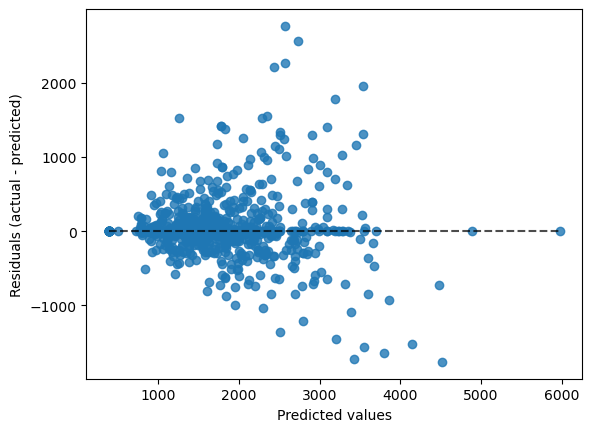

In [103]:
disp = PredictionErrorDisplay(y_true=np.exp(y_test),y_pred=np.exp(vrg.predict(X_test_scaled)))
disp.plot()

## Reduce Complexity

In [52]:
# Reduce num of included models based on weights to top 5
estimators = [('rfr',rfr),('bag',bag),
              ('knn',knn),('svp',svp),('lasso',lasso)]


vrg = VotingRegressor(estimators,
                     weights=[4,3,5,2,1],
                     n_jobs=-1)

vrg.fit(X_train_scaled, y_train)

VotingRegressor(estimators=[('rfr',
                             RandomForestRegressor(max_features='sqrt',
                                                   n_estimators=39,
                                                   random_state=42)),
                            ('bag',
                             BaggingRegressor(n_estimators=49, n_jobs=-1,
                                              random_state=42)),
                            ('knn',
                             KNeighborsRegressor(n_jobs=-1, n_neighbors=12, p=1,
                                                 weights='distance')),
                            ('svp',
                             SVR(C=0.49000000000000005,
                                 coef0=0.49000000000000005, degree=4,
                                 kernel='poly')),
                            ('lasso',
                             LassoCV(cv=15, max_iter=5000, n_alphas=1000,
                                     n_jobs=-1, random_state=42))],
                n_jobs=-1, weights=[4, 3, 5, 2, 1])

In [53]:
# Training CV Score
vrg_cvs = cross_val_score(vrg,X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

vrg_score_red = score_info(vrg_cvs)

Mean: 0.03011226418139966
STD: 0.005699618946530474
Conf. Interval: (0.026845137991297684, 0.03337939037150164)


In [54]:
# Test CV Score
vrg_cvs_test = cross_val_score(vrg,X_test_scaled,y_test,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

vrg_score_test_red = score_info(vrg_cvs_test)

Mean: 0.04392950418292037
STD: 0.012709683758515685
Conf. Interval: (0.036644080180911025, 0.05121492818492971)


In [56]:
# Estimate Bias and Variance

mse,bias,var = bias_variance_decomp(vrg,X_train_scaled, y_train, X_test_scaled, y_test, loss='mse',
                                       num_rounds=200, random_seed=42)
print(f'Estimated Bias: {bias}')
print(f'Estimated Variance: {var}')

Estimated Bias: 0.0333711450357201
Estimated Variance: 0.002962361987600077


In [55]:
# Display Score on train vs. test
print(f'Training Score: {vrg.score(X_train_scaled, y_train)}')
print(f'Testing Score: {vrg.score(X_test_scaled, y_test)}')

Training Score: 0.9665733108243135
Testing Score: 0.8674088214683138


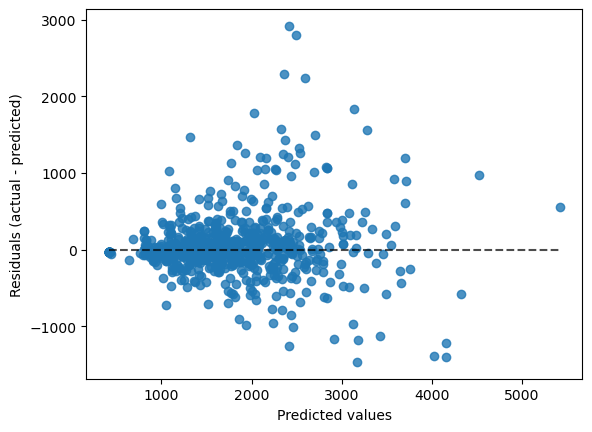

In [109]:
disp2 = PredictionErrorDisplay(y_true=np.exp(y_test),y_pred=np.exp(vrg.predict(X_test_scaled)))
disp2.plot()

In [133]:
# joblib.dump(vrg,'mod_params/vrg_city_final.pkl')

['mod_params/vrg_city_final.pkl']

## Plots

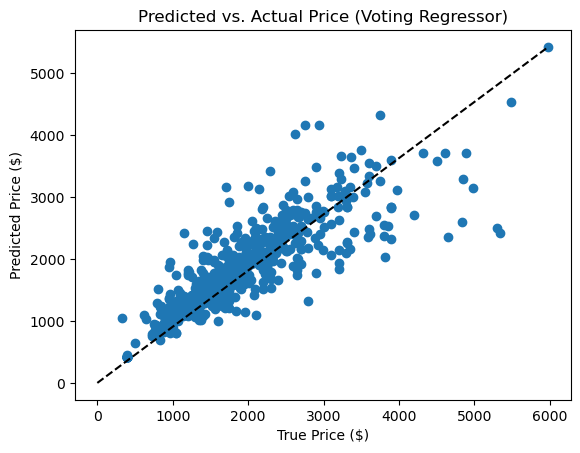

In [113]:
plt.figure()
plt.scatter(np.exp(y_test),np.exp(vrg.predict(X_test_scaled)))
plt.plot([0,np.max(np.exp(y_test))],[0,np.max(np.exp(vrg.predict(X_test_scaled)))],'--k')
plt.axis('tight')
plt.xlabel('True Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Predicted vs. Actual Price (Voting Regressor)')
plt.savefig('figs/pred_vs_actual_vrg_with_city.png')

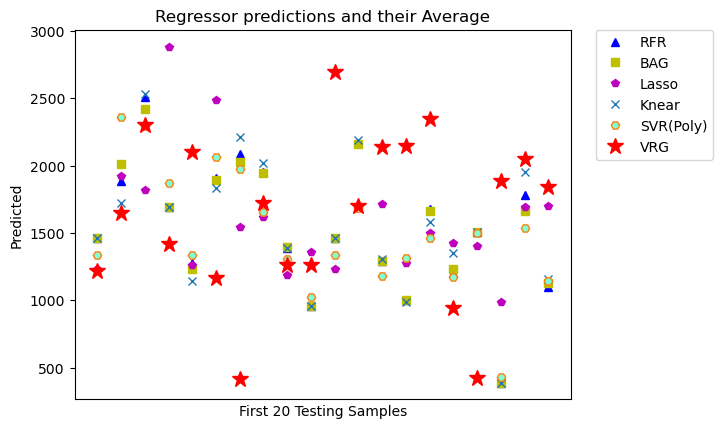

In [129]:
plt.figure()
plt.plot(np.exp(rfr_pred[:20]),'b^',label='RFR')
plt.plot(np.exp(bag_pred[:20]),'ys',label='BAG')
plt.plot(np.exp(lasso_pred[:20]),'pm',label='Lasso')
plt.plot(np.exp(knn_pred[:20]),'x',label='Knear')
plt.plot(np.exp(svp_pred[:20]),'H',markerfacecolor='aquamarine',label='SVR(Poly)')
plt.plot(np.exp(vrg.predict(X_test_scaled)[:20]),'r*',label='VRG', markersize=12)

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("Predicted")
plt.xlabel("First 20 Testing Samples")
plt.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0)
plt.title("Regressor predictions and their Average")
plt.title("Regressor predictions and their Average")
# plt.savefig('figs/pred_vs_avg_with_city.png')
plt.show()

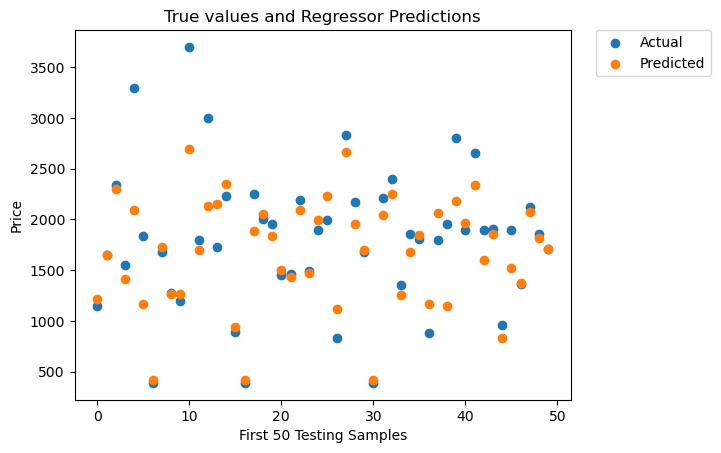

In [123]:
plt.figure()
plt.scatter(range(0,len(np.exp(y_test[:50]))),np.exp(y_test[:50]),label='Actual')
plt.scatter(range(0,len(np.exp(vrg.predict(X_test_scaled)[:50]))),
            np.exp(vrg.predict(X_test_scaled)[:50]),label='Predicted')

plt.ylabel("Price")
plt.xlabel("First 50 Testing Samples")
plt.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0)
plt.title("True values and Regressor Predictions")
# plt.savefig('figs/true_vs_pred.png')
plt.show()